In [1]:
__author__ = 'Mike Fitzpatrick <fitz@noao.edu>' # single string; emails in <>
__version__ = '20201212' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['sdss_dr8','sdss_dr9','sdss_dr10','sdss_dr11','sdss_dr12', 'sdss_dr13','sdss_dr14','sdss_dr15','sdss_dr16']
__keywords__ = ['tutorial','spectra','data access']

# Getting Started with Spectral Data
*Mike Fitzpatrick, Astro Data Lab Team*

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [Finding available spectral datasets](#find)
* [Querying for spectra](#qspec)
* [Retrieving data](#retrieve)
* [Plotting spectra](#plot)
* [References and Resources](#refs)

<a class="anchor" id="goals"></a>
# Goals
Learn how to:
* Import necessary Python modules
* Discover available spectral datasets
* Create lists of object identifiers
* Retrieve one or more spectra
* Plot spectra in a notebook

<a class="anchor" id="summary"></a>
# Summary

This notebook aims to provide you with a very quick overview of how to find, retrieve and utilize spectral data available within Data Lab.  A more detailed explanation of the *specClient* interface can be found in the associated *HowTo* notebook, a complete science example using this service is also available in this directory tree.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php


<a class="anchor" id="import"></a>
# Imports and setup
To use the spectral services you will normally want to import common packages such as NumPy, Pandas and matplotlib. Several *astropy* packages are included below for demonstration but are not specifically required, although useful.

For saving query results in virtual you'll need the *storeClient* module *and* log in as an authenticated user.  The *queryClient* interface is only needed if you wish to query Data Lab catalogs directly. 

In [2]:
# Standard libs
from getpass import getpass               # for login password prompts

import time
import numpy as np                        # for manipulating arrays
from specutils import Spectrum1D          # spectrum data model
import json                               # to pretty-print dicts

from astropy import units as u            # astropy utilities
from astropy.coordinates import SkyCoord
from astropy.table import Table

from matplotlib import pyplot as plt      # visualization libs
from IPython.display import display
%matplotlib inline

# Data Lab imports
#from dl import specClient as spec         # primary spectral data client interface
import specClient as spec         # primary spectral data client interface

from dl import storeClient                # needed to use virtual storage
from dl import queryClient                # needed to query Data Lab catalogs
from dl import authClient                 # needed for login authentication

<a class="anchor" id="auth"></a>
# Authentication
For the purposes of this notebook, there is no need to log in with your username and password inside the notebook. All spectral data is currently public and can be accessed as an 'anonymous' user.  Authentication is only required if you wish to save results (e.g. identifier lists or spectra) to virtual storage where an account is required.

Uncomment the *login()* command below to log in, otherwise the cell will simply print the username used to access the data.

In [3]:
# Get token for an authenticated user if you wish to use virtual storage
#token = authClient.login(input("Enter user name: "),getpass("Enter password: "))
authClient.whoAmI()

'fitz'

<a class="anchor" id="find"></a>
# Finding available spectral datasets

## Contexts and Catalogs
Similar to the database *schema* used for catalogs, the spectral data are divided into *contexts* that define aspects of a particular survey or data release, e.g. rest vs observed wavelengths, flux units, etc.  In the backend service this context name is used to locate and read the data which may be stored in different ways depending on the survey or release.

Within each *context* there may be one or more *catalogs* that are suitable for use in locating spectra, e.g. they provide a unique object identifier that can later be used to retrieve data.  These catalogs typically live in the available Data Lab catalog services but can equally be a user's *MyDB* table provided the identifiers are appropriate for the context.

## What datasets are available?
The *specClient* has a <tt>list_contexts()</tt> method to give you information about available dataset contexts and a <tt>catalogs()</tt> method to list catalogs within each context.  If we call <tt>specClient.list_contexts()</tt> with no argument, we'll get information on the contexts and a one-line description for most of them.

In [4]:
print(spec.list_contexts())

         default   Default data context (default: sdss_dr16)
       sdss_dr16   SDSS DR16 coadded spectra from BOSS/eBOSS/SDSS (cached)
       sdss_dr15   SDSS DR15 coadded spectra from BOSS/eBOSS/SDSS
       sdss_dr14   SDSS DR14 coadded spectra from BOSS/eBOSS/SDSS
       sdss_dr13   SDSS DR13 coadded spectra from BOSS/eBOSS/SDSS
       sdss_dr12   SDSS DR12 coadded spectra from BOSS/SDSS
       sdss_dr11   SDSS DR11 coadded spectra from SDSS
       sdss_dr10   SDSS DR10 coadded spectra from SDSS
        sdss_dr9   SDSS DR9 coadded spectra from SDSS
        sdss_dr8   SDSS DR8 coadded spectra from SDSS



To get a look at the configuration of each context, simply supply the name to 'list_contexts()', e.g.:

In [5]:
print(json.dumps(spec.list_contexts('default'),indent=4))

{
    "description": "Default data context (default: sdss_dr16)",
    "type": "public",
    "catalog": "sdss_dr16.specobj",
    "id_main": "specobjid",
    "redshift": "z",
    "rest_frame": "false",
    "catalogs": {
        "sdss_dr16.specobj": "SDSS primary spectra (cleaned table) [DEFAULT]",
        "sdss_dr16.specobjall": "SDSS primary spectra (may contain duplicates",
        "sdss_dr16.segue1specobjall": "SDSS primary spectra - SEGUE-1 survey",
        "sdss_dr16.segue2specobjall": "SDSS primary spectra - SEGUE-2 survey",
        "sdss_dr16.seguespecobjall": "SDSS primary spectra - All SEGUE survey",
        "sdss_dr16.sdssebossfirefly": "eBOSS Firefly Value-added Catalog"
    }
}


You are able to *get* and *set* the context from within the interface as well:

In [6]:
print(spec.get_context())                 # print the current context name
status = spec.set_context('sdss_dr16')    # set the interface context
print(spec.get_context())                 # print the new context name

default
sdss_dr16


## Get list of catalogs
If we call *spec.catalogs()* with a specific context name, we'll see what catalogs are available for that dataset.  For example, here's what's available for the default SDSS DR16 context:

In [7]:
print(spec.catalogs(context='sdss_dr16'))

Catalogs used by 'sdss_dr16' context:

             sdss_dr16.specobj   SDSS primary spectra (cleaned table) [DEFAULT]
          sdss_dr16.specobjall   SDSS primary spectra (may contain duplicates)
    sdss_dr16.segue1specobjall   SDSS primary spectra - SEGUE-1 survey
    sdss_dr16.segue2specobjall   SDSS primary spectra - SEGUE-2 survey
     sdss_dr16.seguespecobjall   SDSS primary spectra - All SEGUE survey
    sdss_dr16.sdssebossfirefly   eBOSS Firefly Value-added Catalog



The default 'catalog' listed here is what will be used by the *query()* method when searching for spectra, but as we'll see below there is an option in that method to specify alternate catalogs to be used.

<a class="anchor" id="qspec"></a>
# Querying for spectra
Once we have identified the dataset we wish to use, we need to generate a list of identifiers that will later be used to retrieve the spectra.  The exact form of an 'identifier' depends somewhat on the dataset, e.g. for SDSS there is a 64-bit unsigned integer *specobjid* field in the catalogs, but spectra may also be referred to as an '(*plate, mjd, fiber*)' tuple for a specific data release and reduction version (i.e. the *run2d*).  When retrieving data you may use a single identifier or an array of idkkjentifiers to retrieve multiple spectra.
  
The interface provides a <tt>specClient.query()</tt> method to find spectra using various position-based queries, however the identifier list can just as easily be created by any other query of Data Lab tables. See the *How to Use the Spectral Data Client* notebook for detailed options available in the *query()* method.

The *query()* may be called as:

            id_list = query (<region> | <coord, size> | <ra, dec, size>,
                             out=None, constraint=<sql_where_clause>,
                             context=None, profile=None, **kw)
                             
                where:
                    region      Array of polygon vertex tuples (in deg)
                    coord       Astropy SkyCoord object
                    ra, dec     RA/Dec position (in deg)
                    size        Search size (in deg)
                    out         Save query results to filename
                    constraint  A valid SQL 'where' clause
                    context     Dataset context
                    profile     Service profile
                    kw          optional parameters

                returns:
                    An array of object identifiers for the given context. The
                    id types will be specific to the dataset and selected by
                    a 'fields' kw param or from a specific table, e.g. for 

                kw options:
                    for context='sdss_dr16':
                        fields:
                            specobjid           # or 'bestobjid', etc             (Default)
                            tuple               # a plate/mjd/fiber/run2d tuple   (Not Yet Implemented)
                        primary:
                            True                # query sdss_dr16.specobj
                            False               # query sdss_dr16.specobjall
                        catalog:
                            <schema>.<table>    # alternative catalog to query

                    for all contexts/profiles:
                        timeout=<timeout>       # query timeout
                        token=<token>           # to pass alternate auth token
                        debug                   # client debug flag
                        verbose                 # client verbosity flag

The only requirement is that an identifier be either a single object (e.g. an integer, tuple, string, etc), or an array of such objects. Depending on the data context, identifiers may also be specified in a way that implies multiple spectra are to be retrieved, e.g. to get all fibers on an SDSS plate without requiring the list of fiber numbers be created explicitly.

### Example 1)  Find spectra by RA/Dec position
Call *query()* by specifying the RA, Dec and search size in decimal degrees:

In [8]:
id_list = spec.query(30.0, 1.0, 0.025)
print (str(id_list))

[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]


The result in this case is a 1-D array of SDSS *specobjid* identifiers.

### Example 2)  Find spectra using an Astropy *SkyCoord* object to specify position.  

The *SkyCoord* can be instantiated in a number of ways, however the search size must still be specified in decimal degrees.

In [9]:
posn = [ SkyCoord(ra=30.0*u.degree, dec=1.0*u.degree, frame='icrs'),   # explicit RA,Dec using astropy units
         SkyCoord(ra=30.0, dec=1.0, frame='icrs', unit='deg'),         # explicit RA,Dec position
         SkyCoord('2h0m0.0s +1d0m0s', frame='icrs')                    # sexagesimal position
       ]

for p in posn:
    print(spec.query(p, 0.025))
    print('-------')

[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]
-------
[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]
-------
[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]
-------


Here, for each of the *SkyCoord* objects (all representing the same position) we print the 1-D array of identifiers.

### Example 3)  Find spectra within a polygonal region of the sky.

An array containing the vertices of a polygon (specified in decimal degrees) may be use to search for spectra.  The polygon is specified as a 1-D array with successive pairs of (ra,dec) values defining each vertex of the polygon and the last vertex does not need to be the same as the first to close the polygon.

In [10]:
region = [29.95,0.95, 30.05,0.95, 30.05,1.05, 29.95,1.05]
print(spec.query(region))

[8822599620880519168 1694626468820183040 8255302463378444288
 1210486485086660608 1210489508743636992 3226968571238180864
 1750919545821882368 1750917896554440704 3226968021482366976
 1750920370455603200 4767234020315779072 1750921744845137920
  789367746562385920 1750921195089324032  453893824498919424]


### Example 4)  Create identifiers from Data Lab

Internally, the `query()` method uses the Data Lab *queryClient* to generate the identifier list. This can be done directly when more complex queries are needed (e.g. to join with a MyDB, make color cuts, etc).  For example,

In [11]:
query = 'select specobjid from sdss_dr16.specobj where z > 1.0 order by z limit 10'
response = queryClient.query(sql=query, fmt='array', dtype=np.uint64)

ids = np.uint64(response)         # convert array elements to correct unsigned-int64 type
print(ids)

[10365155617640042496 10366246057961345024  7633728197453172736
 10833661927714213888  6003362450183049216  8626660053083246592
  5027224271317127168 12476123396898574336 10754718911683645440
  9078196222041542656]


Note, however, that we had to convert the 'specobjid' retrieved directly from the database to an unsigned 64-bit integer value in order for it to be interpreted correctly.  This is because of how the value is stored in the database on the server, the 'specClient.query()' interface takes care of conversions like this automatically, e.g. an all-sky query with the same constraint:

In [12]:
ids = spec.query (0.0, 0.0, 180.0, constraint='z > 1.0 order by z limit 10')
print(ids)

['10365155617640042496' '10366246057961345024' '7633728197453172736'
 '10833661927714213888' '6003362450183049216' '8626660053083246592'
 '5027224271317127168' '12476123396898574336' '10754718911683645440'
 '9078196222041542656']


## Constraining query results, all-sky queries and multiple return fields

The '*constraint*' parameter can be specified as a valid SQL '*where*' clause to further constrain the result.  For example, to select above a certain redshift value and sort the results accordingly.

Note the '*constraint*' is appended to the query submitted by the database directly and so any quoted values must use single-quotes.

In [13]:
# Constraint tests
print(spec.query(30.0,1.0,0.05, out='',
                 constraint='z > 0.2 order by z limit 10'))

[1750919545821882368 4767234020315779072 1750921744845137920
 3226968571238180864  789367746562385920]


If no positional arguments are supplied to the '*query()*' call, an 'all-sky' query will be performed.  Note that a '*constraint*' SHOULD be specified to avoid returning all rows in the catalog.

The optional '*fields*' parameter can be specified to request other values from the catalog in the query (the default object ID field is always returned) in a single result table.  That result table can be used when retrieving the data without change.  For example, to get the IDs and redshifts from an all-sky query of objects in a specific redshift range:

In [14]:
tab = spec.query(fields='specobjid,z,zerr', constraint='z between 0.5 and 0.6 limit 10')
tab

specobjid,z,zerr
int64,float64,float64
2887956423424108544,0.556135,0.000255107
2887955873668294656,0.552192,0.000234394
2887957522935736320,0.556515,9.30667e-05
2887948451964807168,0.550663,0.000171044
2887957797813643264,0.556518,0.000190587
2887944603674109952,0.556119,0.000181073
2887958897325271040,0.557462,0.000254112
2887948726842714112,0.539359,0.000415408
2887960546592712704,0.556839,0.000243797


<a class="anchor" id="retrieve"></a>
# Retrieving data
Data can be retrieved from the service using the `getSpec()` method. The only required argument is either a single object ID, or an array of such IDs which return multiple spectra. When given a single identifier a single spectrum in the requested output format is returned; when given an array of identifiers and array of those objects is returned. 

The `getSpec()` method may be called as:


            list = getSpec  (id_list, fmt='numpy',
                             out=None, align=False, cutout=None, values='all',
                             context=None, profile=None,
                             **kw)
                where:
                    id_list     List of object IDs (dataset-specific).
                                Must be one of:
                                    - single string/int/int64/tuple identifier
                                    - python array/list object
                                    - string of identifier values (one/line)
                                    - filename containing identifiers (one/line)
                                    - VOS name containing identifiers (one/line)
                    fmt         Result format, one of:
                                    'numpy'
                                    'pandas'
                                    'Spectrum1D'
                                    'Spectrum1DCollection'
                                    'Spectrum1DList'
                                    'FITS'
                    out         Output file location (fmt=FITS)
                    align       Align spectra to common wavelength grid (bool)
                    cutout      Cutout range as '<start>-<end>'
                    values      A comma-delimited string of which values to retrieve,
                                a combination of 'flux,model,sky,ivar' or 'all'
                    context     Dataset context
                    profile     Service profile
                    kw          optional parameters

                returns:
                    An array of data objects in the requested format, or a
                    single object of the requested type when the ID list is
                    not an array.  If the 'out' parameter is specified data
                    are saved to the specified directory and an 'OK' string
                    is returned, or progress output in verbose=True.

Supported output formats currently include:

                   numpy                A Numpy array
                   pandas               A Pandas DataFrame
                   Spectrum1D           A 'specutils' Spectrum1D object
                   Spectrum1DList       A list of Spectrum1D objects
                   Spectrum1DCollection A 'specutils' SpectrumCollection object
                   table                An Astropy Table
                   FITS                 The original FITS file
                   
Each format contains the following value arrays:

    loglam      The log-lambda wavelength array
    flux        The flux array
    sky         The sky spectrum array
    ivar        The inverse variance array 
    
Certain datasets may contain additional information such as a 'model' spectrum, or a different kind of error array. The documentation for each dataset context will provide a detailed list of available values

In [15]:
# Utility routine to print information about a spectrum object.
def info(data):
    try:
        print(' Type: ' + str(type(data)))
        if not isinstance(data,Spectrum1D):
            print('  Len: ' + str(len(data)))
            if not isinstance(data,Table):
                print('Shape: ' + str(data.shape))
        if isinstance(data,list) or isinstance(data,np.ndarray):
            print ('Element Type: ' + str(type(data[0])))
    except Exception as e:
        print(e)
        pass
    print('-----------')

### Single-spectrum access
To retrieve a single spectrum, simply pass a single object identifier:

In [16]:
%%time
specobjid = 2210146812474530816      # test SDSS spectrum identifier

# Loop over various return formats.
for fmt in ['numpy','pandas', 'Spectrum1D','tables']:
    print('Format: ' + fmt)
    data = spec.getSpec(specobjid, fmt=fmt)
    info(data)

Format: numpy
 Type: <class 'numpy.ndarray'>
  Len: 3816
Shape: (3816,)
Element Type: <class 'numpy.void'>
-----------
Format: pandas
 Type: <class 'pandas.core.frame.DataFrame'>
  Len: 3816
Shape: (3816, 8)
-----------
Format: Spectrum1D
 Type: <class 'specutils.spectra.spectrum1d.Spectrum1D'>
-----------
Format: tables
 Type: <class 'astropy.table.table.Table'>
  Len: 3816
-----------
CPU times: user 107 ms, sys: 12.3 ms, total: 119 ms
Wall time: 234 ms


### Multi-spectrum access

To retrieve multiple spectra, we need to pass in an *array* of identifiers. For simplicity we'll simply re-use the id_list generated above by a positional *query()* call:

In [17]:
%%time 

# Get list as a numpy array
data = spec.getSpec(id_list, fmt='numpy', align=True)
info(data)

 Type: <class 'numpy.ndarray'>
  Len: 4
Shape: (4, 3846)
Element Type: <class 'numpy.ndarray'>
-----------
CPU times: user 15.6 ms, sys: 3.95 ms, total: 19.6 ms
Wall time: 50.4 ms


Note that here we set the *align* option so that the spectra are all returned on a common wavelength grid, zero-padded on either side as needed. Formats such as 'numpy' often require arrays to be of the same size in order to perform certain operations, and in the case of SDSS the common dispersion means we can align to a common wavelength grid without needing to interpolate data.

<a class="anchor" id="plot"></a>
# Plotting spectra
For single spectra we provide a simple `plot()` method to display the spectrum.  This takes either an identifier (in which case the spectrum is retrieved automatically) or a spectrum object and will display a plot directly which makes is convenient for use in notebooks.  There are a number of options for controlling the plot appearance:

                rest_frame - Whether or not to plot the spectra in the
                             rest-frame  (def: True)
                         z - Redshift value (def: None)
                      xlim - Set the xrange of the plot
                      ylim - Set the yrange of the plot
    
                    values - A comma-delimited string of which values to plot,
                             a combination of 'flux,model,sky,ivar'
                mark_lines - Which lines to mark.  No lines marked if None or
                             an empty string, otherwise one of 'em|abs|all|both'
                      grid - Plot grid lines (def: True)
                      dark - Dark-mode plot colors (def: True)
                  em_lines - List of emission lines to plot.  If not given,
                             all the lines in the default list will be plotted.
                 abs_lines - Lines of absorption lines to plot.  If not given,
                             all the lines in the default list will be plotted.
                 spec_args - Plotting kwargs for the spectrum
                model_args - Plotting kwargs for the model
                 ivar_args - Plotting kwargs for the ivar
                  sky_args - Plotting kwargs for the sky

For example, to plot a spectrum from an identifier:

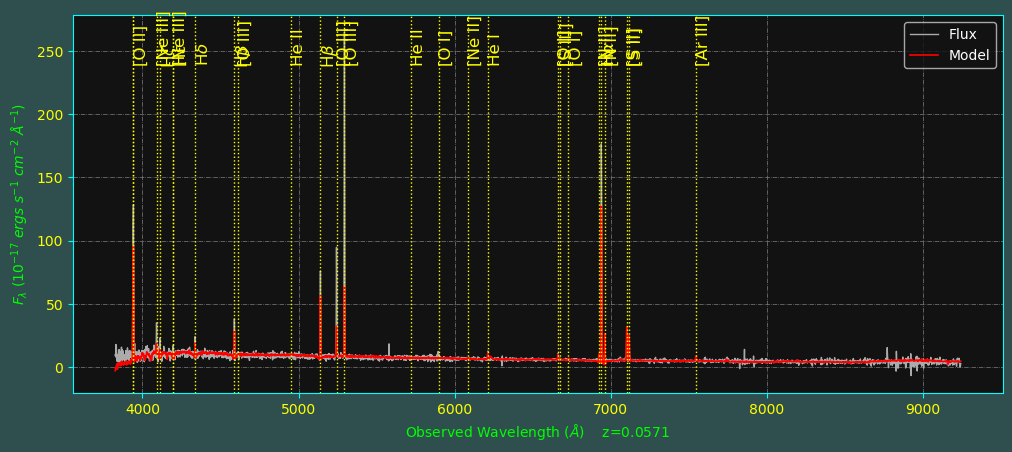

In [18]:
# Create a spectrum ID list for the plot
id_list = spec.query(30.0, 1.0, 25.0, out='', constraint='limit 100')
spec_id = id_list[2]

spec.plot(spec_id, values='flux,model', mark_lines='emission', rest_frame=False)

### Preview Plots

Preview images of all spectra have been pre-computed for fast retrieval or use within user interfaces.  The `preview()` method can be used to retrieve a PNG image given a spectrum identifier.

CPU times: user 29.5 ms, sys: 4.93 ms, total: 34.4 ms
Wall time: 105 ms


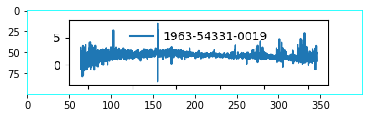

In [19]:
%%time

preview_png = spec.preview(2210146812474530816)
plt.imshow(preview_png)

Another convenience function is the `plotGrid()` method to retrieve a grid of preview images for a list of spectra.  The user can specify the X and Y dimensions of the grid as well as a 'page' number to paginate the list that may be longer than the grid size.  In this case, the grid is generated on the server and returns a PNG image for display.

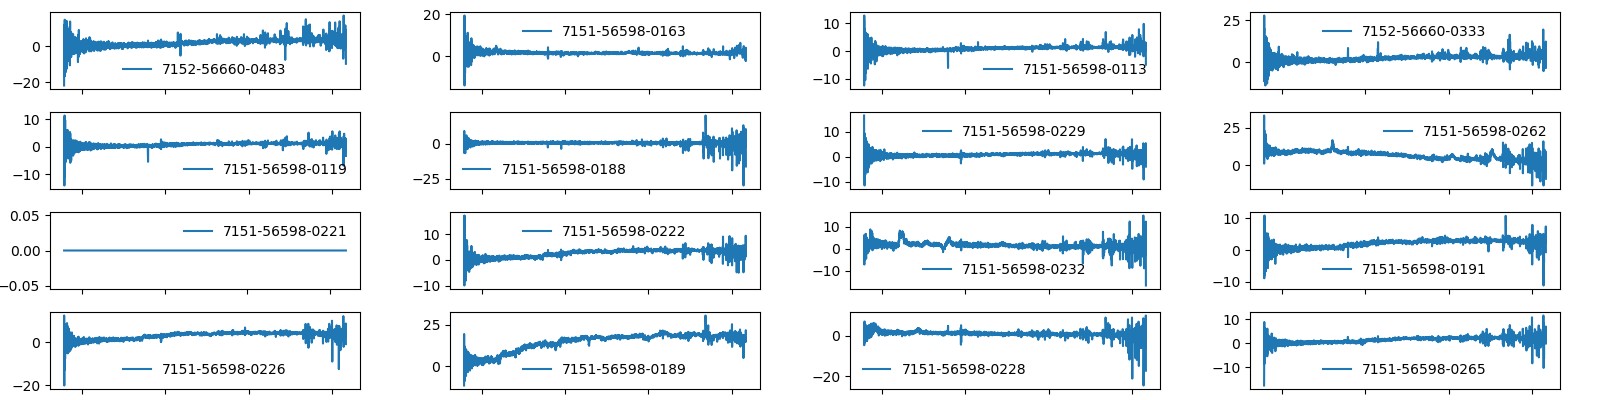

CPU times: user 83.4 ms, sys: 9.05 ms, total: 92.5 ms
Wall time: 307 ms


In [20]:
%%time

grid_png = spec.plotGrid(id_list, 4, 4, page=3, fmt='png')
display(grid_png)

---
<a class="anchor" id="refs"></a>

# References and Resources

* [How To Use the Spectral Data Client](https://github.com/noaodatalab/specserver/blob/master/doc/How_to_use_the_Spectral_Data_Client.ipynb)